In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score,root_mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV



In [37]:
X_train_1 = pd.read_csv("../data/boost/X_train_boost_part1.csv", index_col = "index")
X_train_2 =pd.read_csv("../data/boost/X_train_boost_part2.csv", index_col = "index")
X_train_3 =pd.read_csv("../data/boost/X_train_boost_part3.csv", index_col = "index")
X_train = pd.concat([X_train_1,X_train_2,X_train_3])
y_train = pd.read_csv("../data/y_train.csv", index_col = "index")
X_test =pd.read_csv("../data/boost/X_test_boost.csv", index_col = "index")
y_test = pd.read_csv("../data/y_test.csv", index_col = "index")

# 1. CatBoost

## 1.1 Modelling

reference source:
https://www.datacamp.com/tutorial/catboost?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720821&utm_adgroupid=157156375191&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=720362650048&utm_targetid=dsa-2218886984100&utm_loc_interest_ms=&utm_loc_physical_ms=9062544&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-row-p1_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na-bfcm24&gad_source=1&gbraid=0AAAAADQ9WsG32eomnlc7yr8qhNh_B0rIf&gclid=Cj0KCQiAouG5BhDBARIsAOc08RTtF6F_VSv0Hck1Glr8j0gGVjz_VMrRDLXIkIP5HY1nmm-GCR6qguUaAmvBEALw_wcB

In [38]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features]


We set iterations at 300 and learning rate at 0.1, depth at 6, verbose initially and will adjust them later.

In [39]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, depth=6, verbose=0)
model.fit(X_train, y_train, cat_features=categorical_feature_indices)  

## 1.2 Evaluation

In [40]:
# Make predictions on the train set
y_train_pred = model.predict(X_train)

# Calculate train performance metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Train RMSE: {train_rmse}")
print(f"Train R2 Score: {train_r2}")

Train RMSE: 30189.43254688699
Train R2 Score: 0.969504429945646


In [41]:
# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate test performance metrics
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {test_rmse}")
print(f"Test R2 Score: {test_r2}")

Test RMSE: 30647.69027868796
Test R2 Score: 0.9687033057355025


The RMSE on test and train data sets seem to be both small and R2 Score seems to be high.  We supposed the model performed well because CatBoost can deal with categorical features with a large number of unique values. However, we would like to further check if the model is overfitting or underfitting and how to can further refine and tune the parameters.

We used the approach of validation to plot a graph of training loss and validation loss to check whether over fitting or underfitting occured.

source: https://www.baeldung.com/cs/training-validation-loss-deep-learning

In [42]:

X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


0:	learn: 159099.7771664	test: 159485.4336210	best: 159485.4336210 (0)	total: 817ms	remaining: 4m 4s
100:	learn: 38259.6755813	test: 37159.6154999	best: 37159.6154999 (100)	total: 43.7s	remaining: 1m 26s
200:	learn: 33827.6474552	test: 32585.6248893	best: 32585.6248893 (200)	total: 1m 27s	remaining: 43.2s
299:	learn: 31530.7394108	test: 30284.5024752	best: 30284.5024752 (299)	total: 2m 17s	remaining: 0us

bestTest = 30284.50248
bestIteration = 299



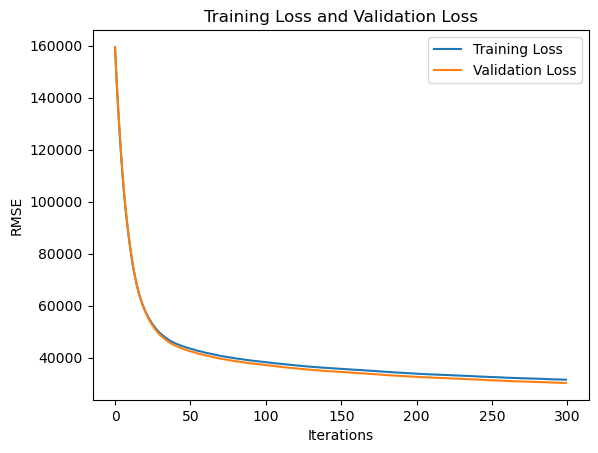

In [43]:
model.fit(X_train, y_train, cat_features=categorical_feature_indices, eval_set=(X_val, y_val), verbose=100)

# Extract metrics
train_loss = model.get_evals_result()['learn']['RMSE']
val_loss = model.get_evals_result()['validation']['RMSE']

# Plot losses
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training Loss and Validation Loss')
plt.show()


According to the graph, both validation and training loss are decreasing, which shows the model is good fitting. 

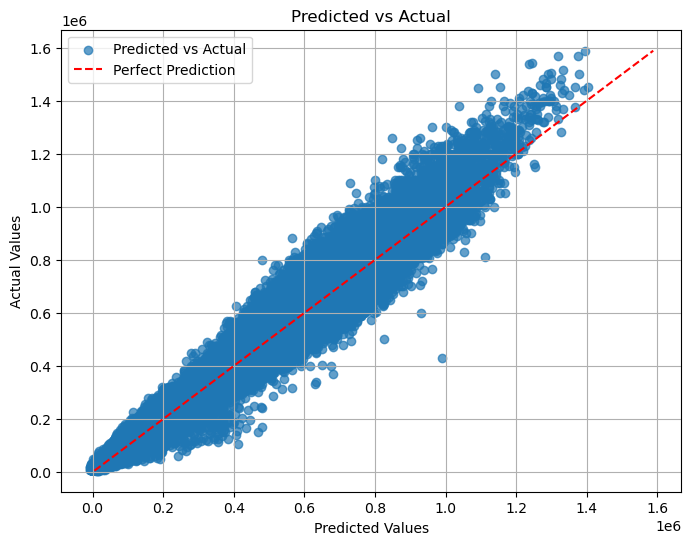

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(True)
plt.legend()
plt.show()

The Predicted vs Actual graph generally shows a linear relationship with a few outliers.

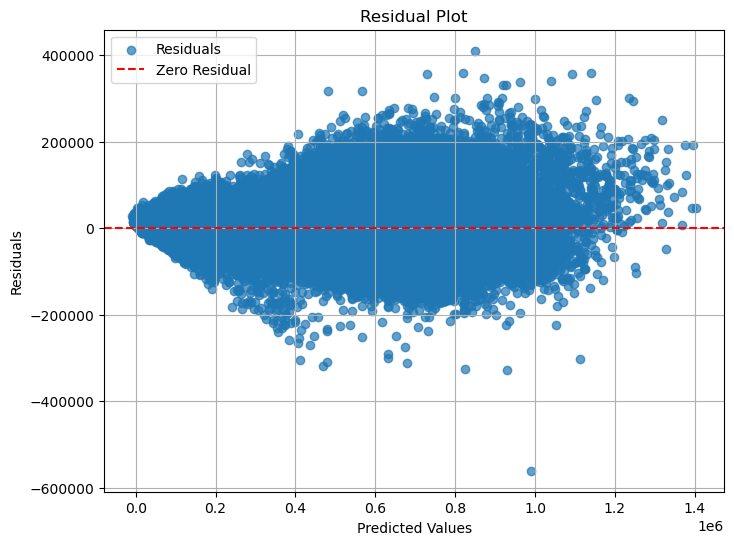

In [45]:

y_train = y_train.squeeze()  # Converts single-column DataFrame to Series
train_residuals = y_train - y_train_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, train_residuals, alpha=0.7, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

Residuals generally spread evenly besides the zero line, without obvious systematic error.

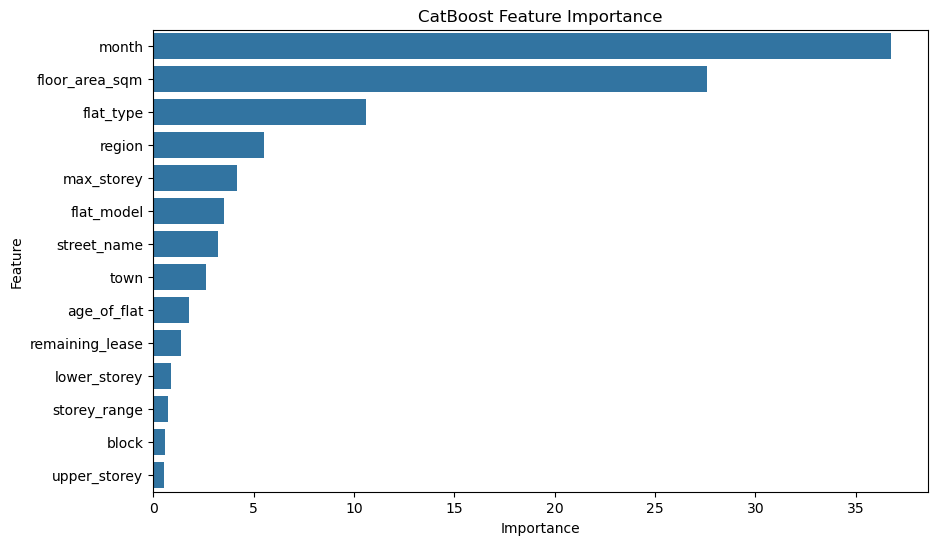

In [46]:
# Extract feature importances from the CatBoost model
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.get_feature_importance()
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importances.head(20))
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Features like "month" "floor_area_sqm" are of great importance, features like "upper_storey" and "block" are of smaller importance.

## 1.3 Refining

### 1.3.1 Reducing Features

In [61]:
feature_importances

,feature,importance
0,month,36.765669
6,floor_area_sqm,27.597387
2,flat_type,10.581478
13,region,5.528814
11,max_storey,4.188496
7,flat_model,3.541038
4,street_name,3.241225
1,town,2.608075
12,age_of_flat,1.803630
8,remaining_lease,1.392650


In [64]:
results = []

for num_features in range(14, 7, -1):  # From 14 features down to 8
    # Select top features
    selected_features = feature_importances['feature'][:num_features]
    X_train_reduced = X_train[selected_features]
    X_test_reduced = X_test[selected_features]
    
    # Update categorical features for reduced feature set
    categorical_features_reduced = X_train_reduced.select_dtypes(include=['object', 'category']).columns
    categorical_feature_indices_reduced = [X_train_reduced.columns.get_loc(col) for col in categorical_features_reduced]
    
    # Train the model
    model_reduced = CatBoostRegressor(cat_features=categorical_feature_indices_reduced, iterations=300, learning_rate=0.1, depth=6,verbose=0) 
    model_reduced.fit(X_train_reduced, y_train)
    
    # Make predictions
    y_train_pred = model_reduced.predict(X_train_reduced)
    y_test_pred = model_reduced.predict(X_test_reduced)
    
    # Evaluate the model
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    results.append({
        'num_features': num_features,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'train_r2': train_r2
    })


results_df = pd.DataFrame(results)
print(results_df)


   num_features    train_rmse     test_rmse   test_r2  train_r2
0            14  29990.043516  30475.527245  0.969054  0.969906
1            13  30064.106580  30540.626252  0.968922  0.969757
2            12  30668.550938  31092.676900  0.967788  0.968529
3            11  30470.574456  30873.558483  0.968240  0.968934
4            10  32377.617555  32863.451727  0.964014  0.964923
5             9  32526.354600  33023.097959  0.963664  0.964600
6             8  33889.830138  34402.516098  0.960565  0.961570


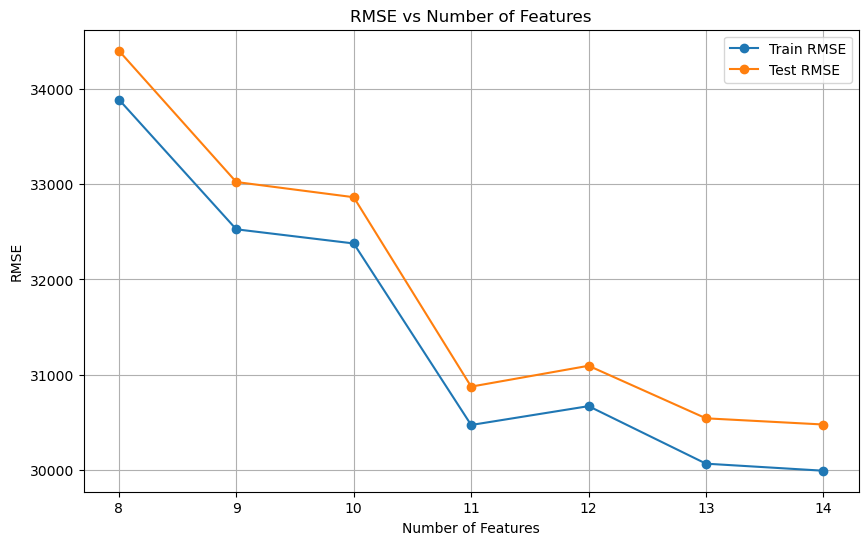

In [65]:

plt.figure(figsize=(10, 6))
plt.plot(results_df['num_features'], results_df['train_rmse'], label='Train RMSE', marker='o')
plt.plot(results_df['num_features'], results_df['test_rmse'], label='Test RMSE', marker='o')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Features')
plt.legend()
plt.grid(True)
plt.show()


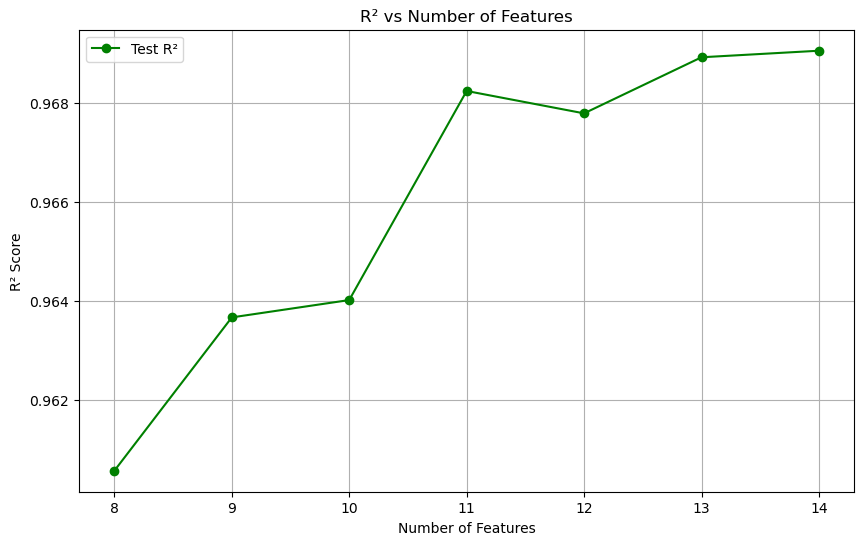

In [66]:
# Plot Test R²
plt.figure(figsize=(10, 6))
plt.plot(results_df['num_features'], results_df['test_r2'], label='Test R²', marker='o', color='green')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.title('R² vs Number of Features')
plt.legend()
plt.grid(True)
plt.show()


### 1.3.2 Tuning Parameters

reference: https://catboost.ai/en/docs/concepts/python-reference_catboost_randomized_search

In [ ]:

model = CatBoostRegressor(cat_features=categorical_feature_indices, verbose=0)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.03, 0.05, 0.1],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [4, 5, 6, 7]
}

# Initialize RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1
)

# Fit RandomizedSearchCV
randomized_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", randomized_search.best_params_)
print("Best Score:", -randomized_search.best_score_)
    

# 2. LightGBM

## 2.1 Modelling

https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/

In [131]:
regressor = lgb.LGBMRegressor()


In [132]:
# Identify categorical columns by their data type
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", categorical_columns)


Categorical columns: ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'region']


In [133]:
# Identify categorical columns
categorical_columns = ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model','region']

# Convert these columns to 'category' type
X_train[categorical_columns] = X_train[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')


https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py

In [134]:
import lightgbm as lgb

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
    "num_leaves": 50,
    "max_depth": -1,
    "learning_rate": 0.01,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.5,
    "bagging_freq": 5,
    "min_data_in_leaf": 20,
    "lambda_l1": 0.5,
    "lambda_l2": 0.5,
    "num_iterations": 1000,
    "verbose": 0,

}

# Prepare the dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Training the model with early stopping
gbm_model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[valid_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Predicting with the model
y_pred = gbm_model.predict(X_test, num_iteration=gbm_model.best_iteration)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 18027.8	valid_0's l2: 7.59702e+08


## 2.2 Evaluation

In [136]:

# Evaluate using mean squared error (MSE)
mse = root_mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)


print(f"Test RMSE: {mse}")
print(f"Test R2 Score: {test_r2}")

Test RMSE: 27562.688682020784
Test R2 Score: 0.9746868538407625


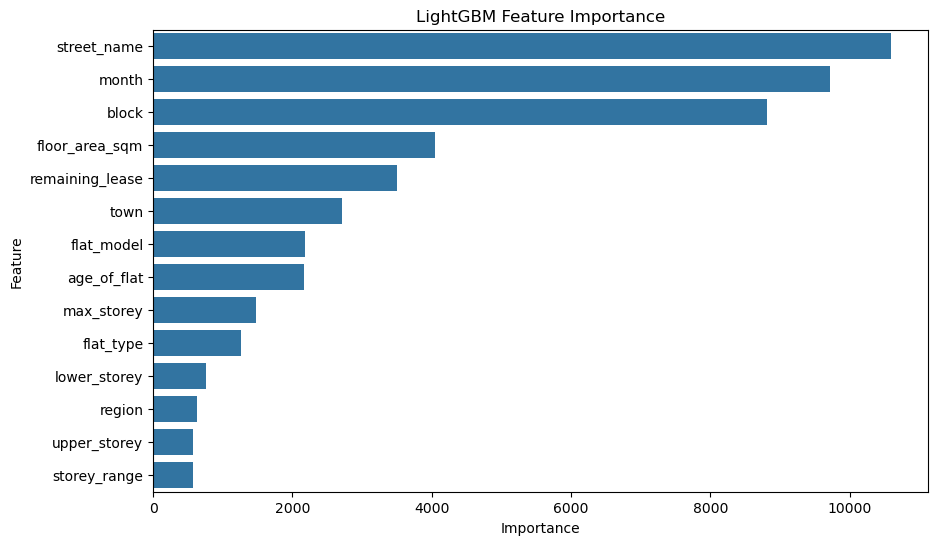

In [137]:
# Getting feature importances from the LightGBM model
feature_importance_values = gbm_model.feature_importance(importance_type='split')
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance_values
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importances.head(20))
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### 